In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('..')
import functions.myfunctions as mf
import tidytcells as tt

In [2]:
vdj = pd.read_csv('data/vdj_cleaned_subset_for_MI.csv', index_col = 0)
vdj = vdj.loc[vdj['Epitope'] != 'KLGGALQAK'] # because too big - takes forever
vdj = mf.prepare_data(vdj, col1 = 'cdr3a_IMGTgaps', col2='cdr3b_IMGTgaps', type = 'cdr3').drop_duplicates(subset = ['cdr3a_IMGTgaps_padded', 'cdr3b_IMGTgaps_padded', 'Epitope'])
print(vdj.shape)

for c in ['V-a', 'V-b', 'J-a', 'J-b']:
    print(c)
    vdj[c] = vdj.apply(
        lambda row: pd.NA if type(row[c]) != str else tt.tcr.standardise(
            gene_name=row[c],
            species=row['Species'],
            precision='gene'
        ),
        axis=1
    )
vdj00 = vdj.dropna(subset=['V-a', 'V-b', 'J-a', 'J-b'])
print('shape before tidytcells: ', vdj.shape, '; shape after tidytcells: ', vdj00.shape)

vdj = vdj00.copy()

(9691, 37)
V-a
V-b
J-a
J-b
shape before tidytcells:  (9691, 37) ; shape after tidytcells:  (9691, 37)


In [3]:
estimatedMI = pd.read_csv('data/output/mutual_info/estimated_mutual_info_all_epitopes.csv')

Plot cute heatmaps with summary of all data

In [4]:
estimatedMI.columns = ['name', 'real', 'shuffle']

estimatedMI[['epitope', 'vars']] = estimatedMI['name'].str.split(pat = '_', n = 1, expand=True)
estimatedMI[['var1','var2']] = estimatedMI['vars'].str.split(pat = '-', n = 1, expand=True)
estimatedMI = estimatedMI.drop(['name','vars'], axis=1)
estimatedMI['real_MI'] = estimatedMI['real'] - estimatedMI['shuffle']
estimatedMI['var1'] = estimatedMI['var1'].replace('cdr3a','CDR3a')
estimatedMI['var2'] = estimatedMI['var2'].replace('cdr3a','CDR3a')
estimatedMI['var1'] = estimatedMI['var1'].replace('cdr3b','CDR3b')
estimatedMI['var2'] = estimatedMI['var2'].replace('cdr3b','CDR3b')
print(estimatedMI)

          real    shuffle     epitope   var1   var2   real_MI
0    15.874756   7.251155   ASNENMETM     Ja  CDR3a  8.623601
1     8.277162   5.880050   ASNENMETM     Ja  CDR3b  2.397112
2     0.816246   0.603484   ASNENMETM     Ja     Jb  0.212762
3     3.891015   2.705514   ASNENMETM     Jb  CDR3a  1.185500
4     9.995252   2.261418   ASNENMETM     Jb  CDR3b  7.733834
..         ...        ...         ...    ...    ...       ...
355   5.359227   4.437795  background     Vb  CDR3a  0.921433
356   7.316673   4.229559  background     Vb  CDR3b  3.087115
357   1.086636   0.884852  background     Vb     Ja  0.201785
358   0.475710   0.346679  background     Vb     Jb  0.129030
359  22.666520  19.730775  background  CDR3a  CDR3b  2.935746

[360 rows x 6 columns]


In [5]:
corrected_matrices = {}
cols = ['Va', 'Ja', 'CDR3a', 'Vb', 'Jb', 'CDR3b']

for ep in vdj['Epitope'].unique().tolist() + ['background', 'Tanno::A1::naive']:
    df = pd.DataFrame(index=cols, columns=cols)
    ss = estimatedMI.loc[estimatedMI['epitope'] == ep]
    for i in range(ss.shape[0]):
        row = ss.iloc[i]
        df.at[row['var1'], row['var2']] = row['real_MI']
        df.at[row['var2'], row['var1']] = row['real_MI']
    corrected_matrices[ep] = df
    # print(df)
    

20.246228877414637
ASNENMETM 14.120535274236257
ATDALMTGF 20.246228877414637
AVFDRKSDAK 8.588514283165825
CINGVCWTV 7.10986465185864
ELAGIGILTV 7.027379303357517
GILGFVFTL 9.31612070117772
GLCTLVAML 17.088625932163936
HGIRNASFI 14.143199848246148
IVTDFSVIK 9.935274014084271
KSKRTPMGF 16.418794022471864
LLWNGPMAV 5.739890338176314
LSLRNPILV 7.846695810317465
LTDEMIAQY 7.039943986689721
NLVPMVATV 8.63389234029936
RAKFKQLL 10.332844682141634
RLRAEAQVK 7.027938305467595
SPRWYFYYL 6.486968316081651
SSLENFRAYV 9.84734528677821
SSPPMFRV 19.773009303143233
SSYRRPVGI 8.299126332319178
TTDPSFLGRY 6.745805703116465
YLQPRTFLL 14.930567549904438
background 9.251177115976542
Tanno::A1::naive 9.282659142285947


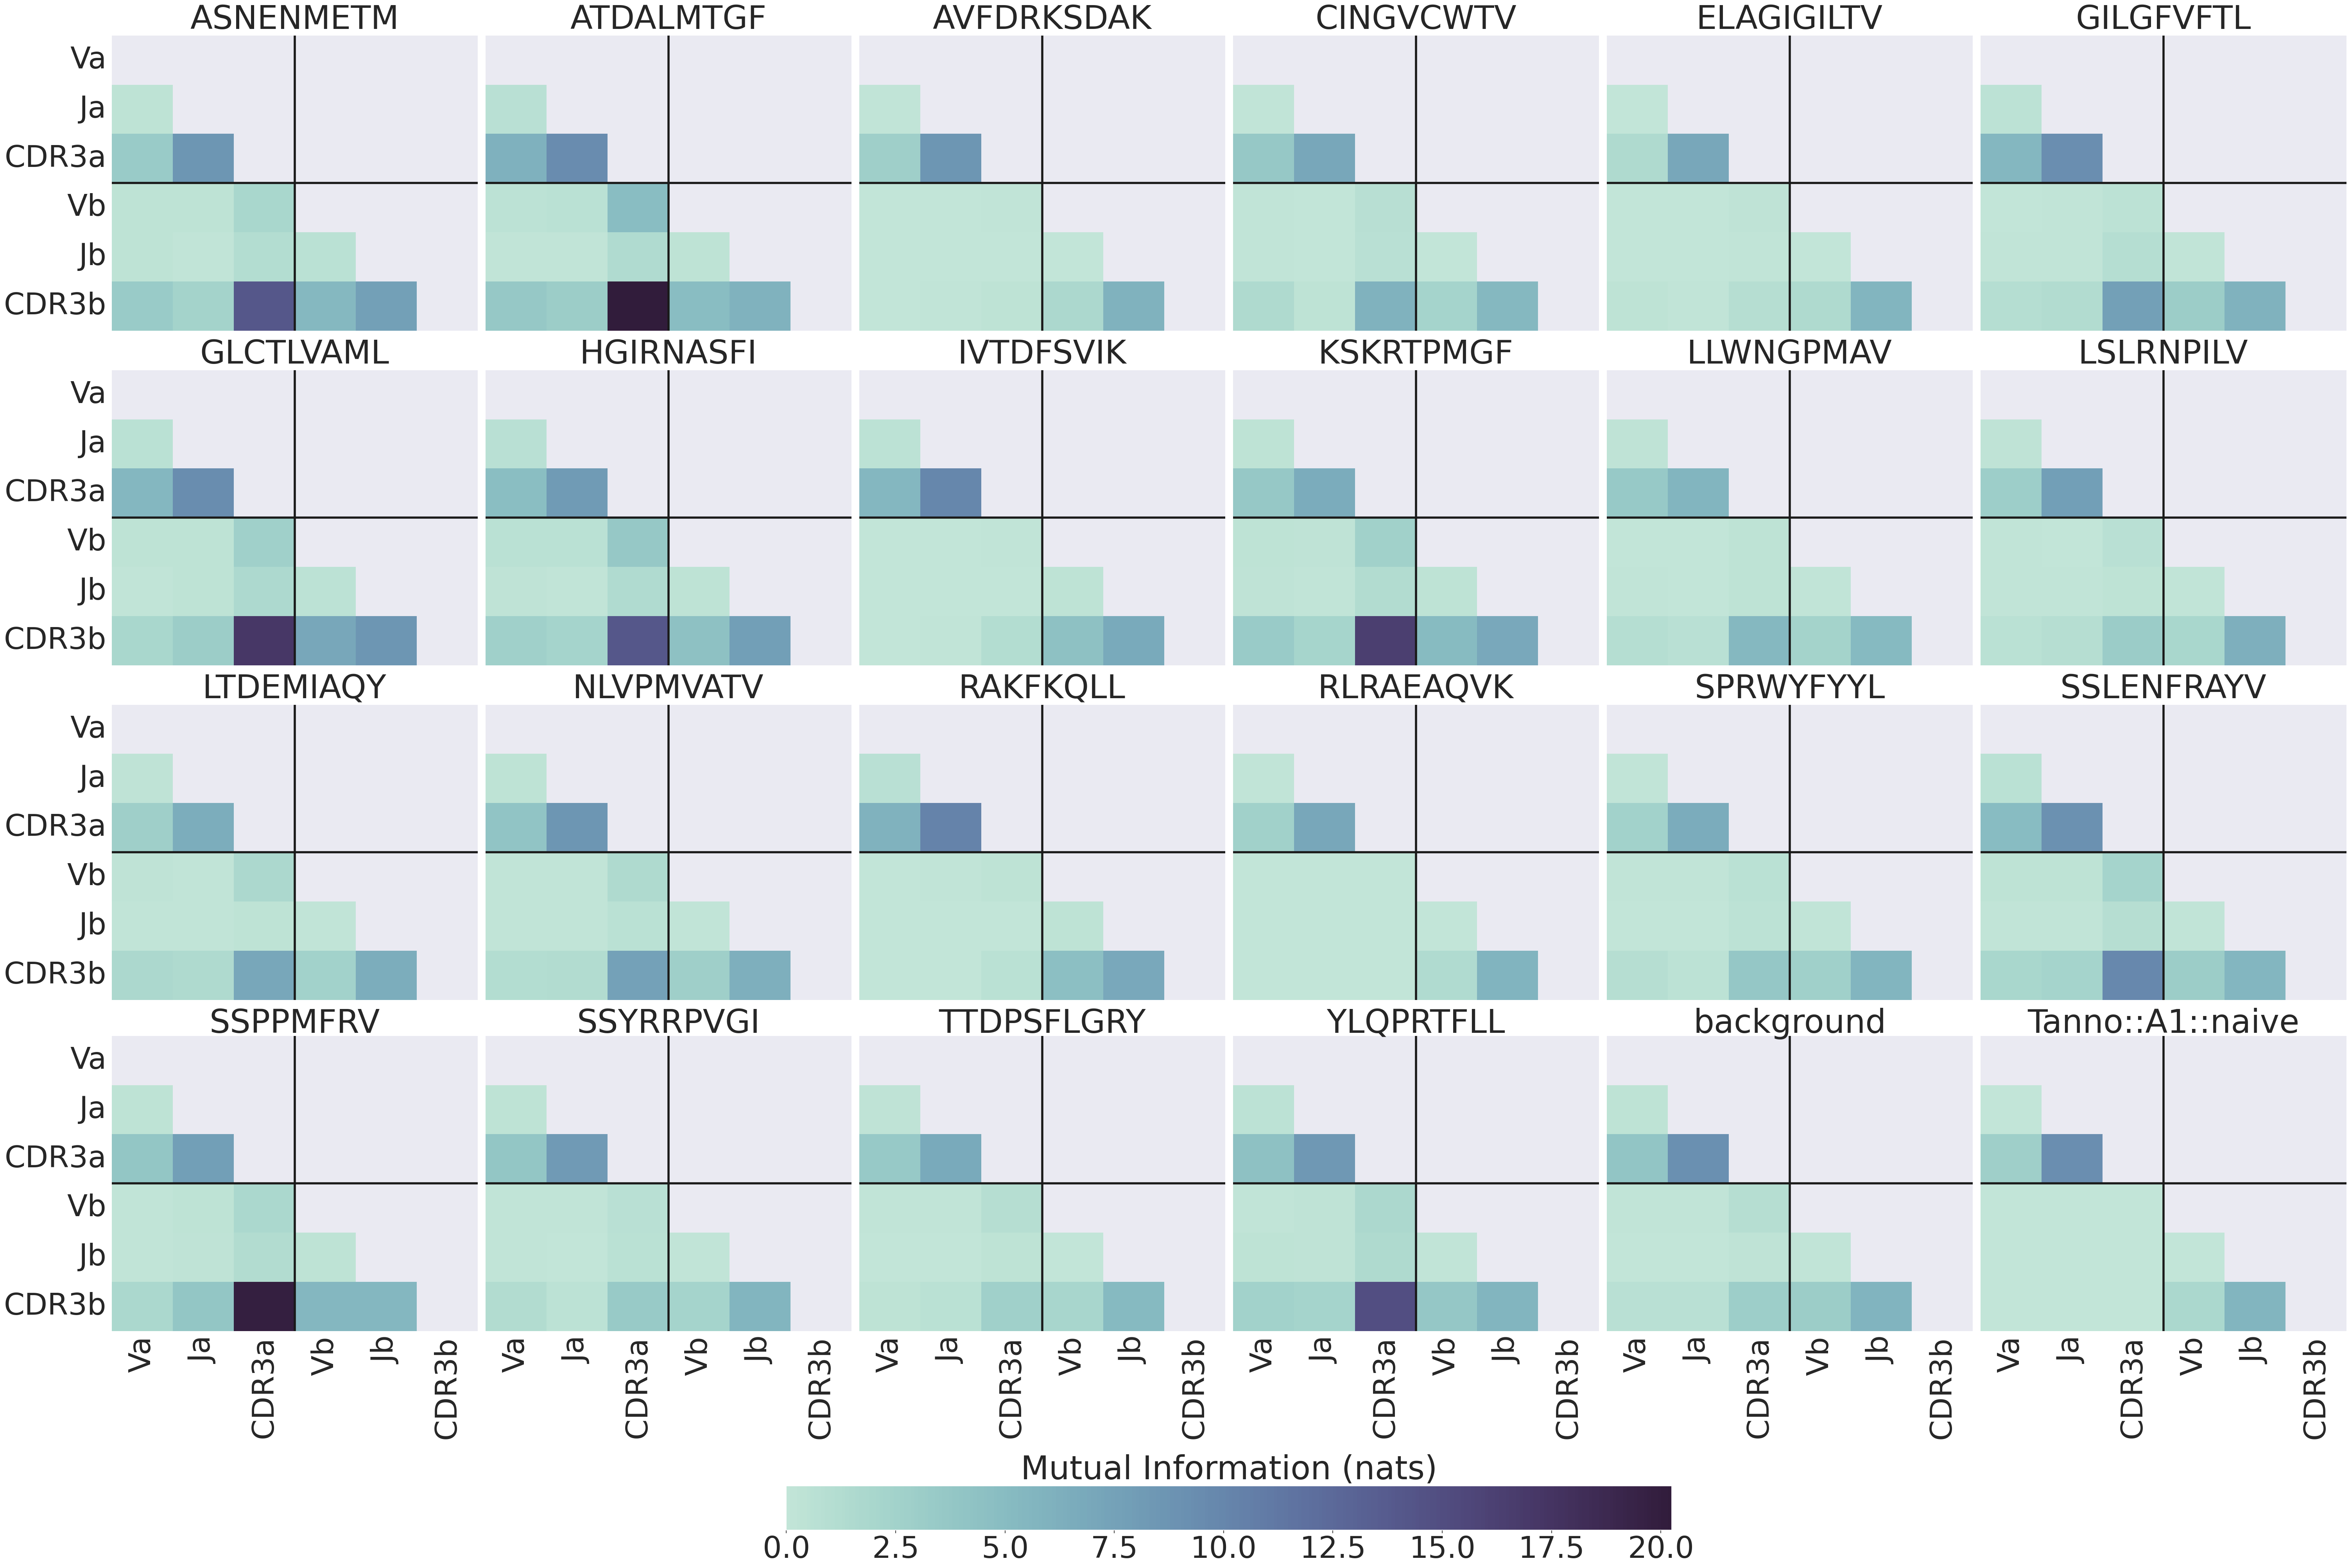

In [6]:
p = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.set(font_scale=5)
f, axs = plt.subplots(figsize=(60,40), ncols=6, nrows=4, sharex = True, sharey=True, constrained_layout=True)
ax = axs.ravel()

vmax = np.nanmax([np.nanmax(corrected_matrices[x]) for x in corrected_matrices])
print(vmax)
for x, k in enumerate(sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']):
    X = corrected_matrices[k]
    print(k, np.nanmax(X))
    matrix = np.triu(X)

    m=sns.heatmap(X.astype('float64'), mask=matrix,
                    cmap = p, ax = ax[x], cbar=False, vmin=0, vmax=vmax)
    ax[x].set_title(k)
    ax[x].axhline(3, c='k', ls='-', lw=4)
    ax[x].axvline(3, c='k', ls='-', lw=4)

cbar = f.colorbar(m.get_children()[0], ax=axs[-1,:], orientation="horizontal")
cbar.ax.set_title('Mutual Information (nats)')
plt.savefig('figures/MutualInformation_all.png')
plt.show()


In [7]:
# try and make a summary plot

xxs = []

for ep in sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']:
    X = corrected_matrices[ep]
    print(X)
    mask = np.ones(X.shape,dtype='bool')
    mask[np.tril_indices(X.shape[0])] = False
    print(mask)
    print(X.mask(mask))

    xx = pd.DataFrame(X.mask(mask).stack(), columns=[ep])
    xxs.append(xx)

summary_df = pd.concat(xxs, axis=1)
print(summary_df)

             Va        Ja      CDR3a        Vb        Jb      CDR3b
Va          NaN  0.354518   3.380775  0.421769   0.40806   3.355351
Ja     0.354518       NaN   8.623601  0.373808  0.212762   2.397112
CDR3a  3.380775  8.623601        NaN  1.939491    1.1855  14.120535
Vb     0.421769  0.373808   1.939491       NaN  0.605945   5.308489
Jb      0.40806  0.212762     1.1855  0.605945       NaN   7.733834
CDR3b  3.355351  2.397112  14.120535  5.308489  7.733834        NaN
[[False  True  True  True  True  True]
 [False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False False  True]
 [False False False False False False]]
             Va        Ja      CDR3a        Vb        Jb CDR3b
Va          NaN       NaN        NaN       NaN       NaN   NaN
Ja     0.354518       NaN        NaN       NaN       NaN   NaN
CDR3a  3.380775  8.623601        NaN       NaN       NaN   NaN
Vb     0.421769  0.373808   1.939491 

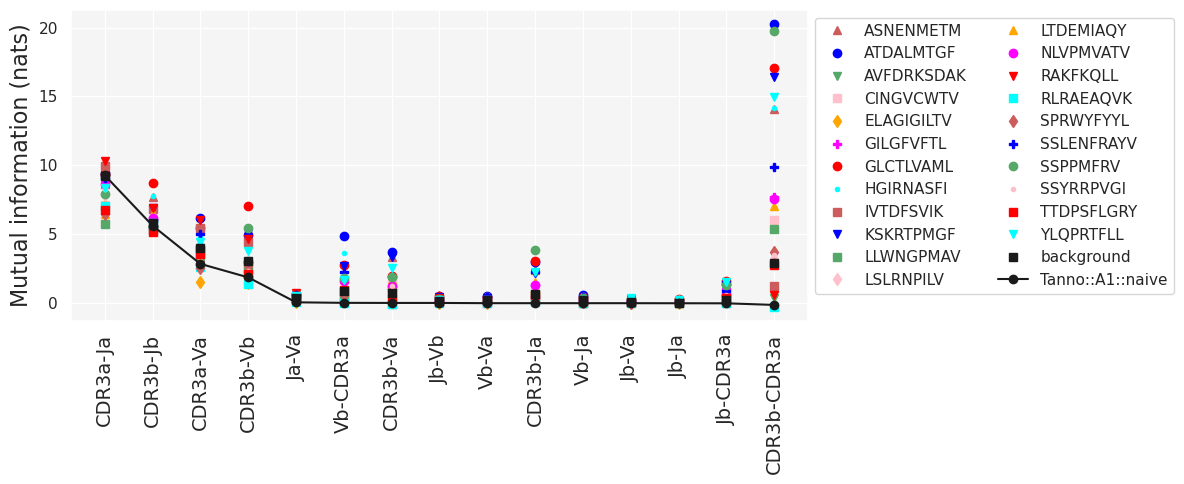

In [8]:
sns.set(font_scale=1)
styles = ['^', 'o', 'v', 's', 'd', 'P','o','.','s','v', 's', 'd','^', 'o', 'v', 's', 'd', 'P','o','.','s','v','s','o-']
colors = ['indianred','blue','g','pink','orange','fuchsia','red','cyan',
          'indianred','blue','g','pink','orange','fuchsia','red','cyan',
          'indianred','blue','g','pink', 'red','cyan','k','k']
f, ax = plt.subplots(figsize=(12,5))
S = summary_df.sort_values(by='Tanno::A1::naive', ascending=False)
P = S.plot(kind='line', style=styles, color=colors, ax=ax)
ax.set_xticks(list(range(0,len(S.index))))
ax.set_xticklabels(labels=['-'.join(x) for x in S.index], rotation=90, fontdict={'size':14})
plt.legend(bbox_to_anchor = [1,1], ncols=2, loc='upper left', facecolor = 'white')
P.set_facecolor("whitesmoke")
ax.set_ylabel('Mutual information (nats)', fontsize=16)
plt.tight_layout()
plt.savefig('figures/MutualInformation_all_summary.png')
plt.show()

1.3451615958274972
0.8880896257524495
1.3451615958274972


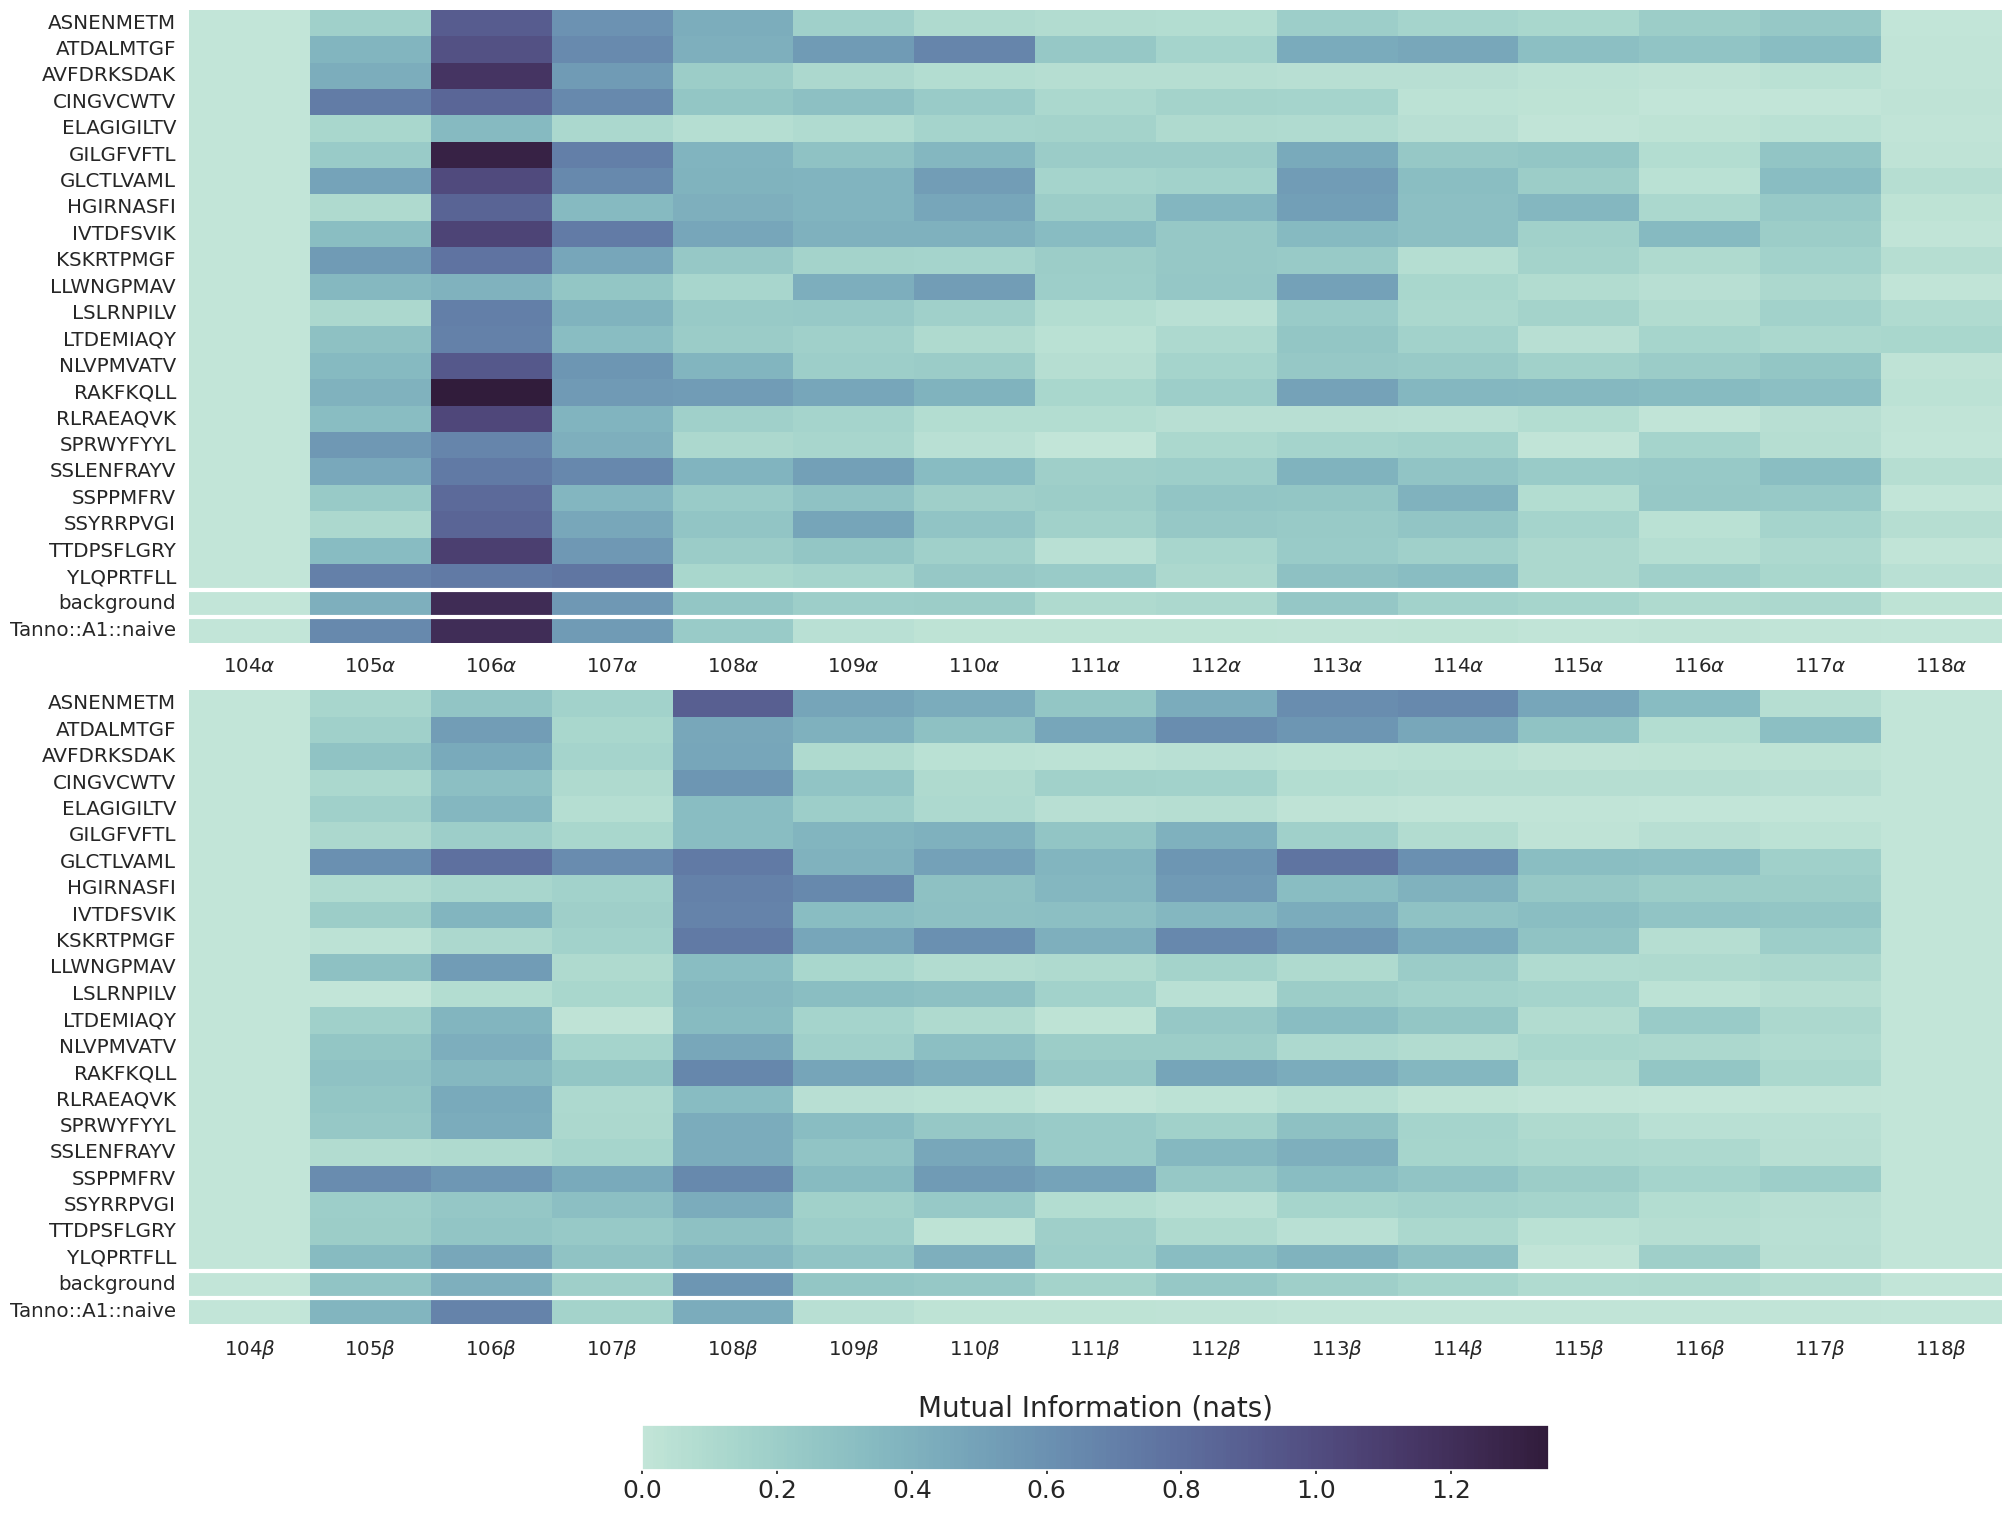

In [9]:
cdr3_res = [104,105,106,107,108,109,110,111,'111.1','111.2','112.2','112.1',112,113,114,115,116,117,118]

all_mi = pd.read_csv('data/output/mutual_info/estimated_mutual_info_all_epitopes_VJ_to_CDR3_by_pos_all_epitopes.csv', index_col=0)

epitopes_a0 = all_mi.loc[all_mi['pair'] == 'Va-CDR3a']
epitopes_a = pd.DataFrame()
for ep in epitopes_a0['epitope'].unique():
    epdf = epitopes_a0.loc[epitopes_a0['epitope'] == ep]
    diff = epdf.loc[epdf['type'] == 'real'][[c for c in epdf.columns if c not in ['epitope', 'type','pair']]].values - epdf.loc[epdf['type'] == 'shuffle'][[c for c in epdf.columns if c not in ['epitope', 'type','pair']]].values
    diff = pd.DataFrame(diff, index=[ep])
    diff['epitope'] = ep
    epitopes_a = pd.concat([epitopes_a, diff])

epitopes_a = epitopes_a.drop('epitope', axis=1)
epitopes_a.columns = [str(x) + r'$\alpha$' for x in cdr3_res]
epitopes_a = epitopes_a.drop([r'112.1$\alpha$', r'111.1$\alpha$', r'112.2$\alpha$', r'111.2$\alpha$'], axis=1)

epitopes_b0 = all_mi.loc[all_mi['pair'] == 'Vb-CDR3b']
epitopes_b = pd.DataFrame()
for ep in epitopes_b0['epitope'].unique():
    epdf = epitopes_b0.loc[epitopes_b0['epitope'] == ep]
    diff = epdf.loc[epdf['type'] == 'real'][[c for c in epdf.columns if c not in ['epitope', 'type','pair']]].values - epdf.loc[epdf['type'] == 'shuffle'][[c for c in epdf.columns if c not in ['epitope', 'type','pair']]].values
    diff = pd.DataFrame(diff, index = [ep])
    diff['epitope'] = ep
    epitopes_b = pd.concat([epitopes_b, diff])
epitopes_b = epitopes_b.drop('epitope', axis=1)
epitopes_b.columns = [str(x) + r'$\beta$' for x in cdr3_res]
epitopes_b = epitopes_b.drop([r'112.1$\beta$', r'111.1$\beta$', r'112.2$\beta$', r'111.2$\beta$'], axis=1)
print(np.nanmax(epitopes_a.values))
print(np.nanmax(epitopes_b.values))
vmax = np.nanmax([np.nanmax(epitopes_a.values), np.nanmax(epitopes_b.values)])
print(vmax)

sns.set()
sns.set(font_scale=1.3)
f, axs = plt.subplots(nrows=2, figsize = (20,15), constrained_layout=True)

sns.heatmap(epitopes_a.loc[sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']],
            cmap = p, ax = axs[0], cbar=False, vmin=0, vmax=vmax)
m = sns.heatmap(epitopes_b.loc[sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']],
                        cmap = p, ax = axs[1], cbar=False, vmin=0, vmax=vmax)
axs[0].axhline(22, c='white', ls='-', lw=3)
axs[0].axhline(23, c='white', ls='-', lw=3)
axs[1].axhline(22, c='white', ls='-', lw=3)
axs[1].axhline(23, c='white', ls='-', lw=3)
cbar = f.colorbar(m.get_children()[0], ax=axs[-1], orientation="horizontal", shrink=0.5)
cbar.ax.tick_params(labelsize=18, size=3)
cbar.ax.set_title('Mutual Information (nats)', fontsize=20)
plt.savefig('figures/MutualInformation_V_cdr3aa.png')
plt.show()

      0    1    2    3    4    5    6    7    8    9  ...       353       354  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.018616  0.019904   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.013214  0.022997   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.009850  0.014752   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.004960  0.011486   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.021903  0.020761   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.018755  0.029254   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.019331  0.069487   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.014974  0.026958   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.019215  0.021370   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.011451  0.024735   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.001867  0.024072   
11  0.0  0.0  0.0  0.0  0.0 

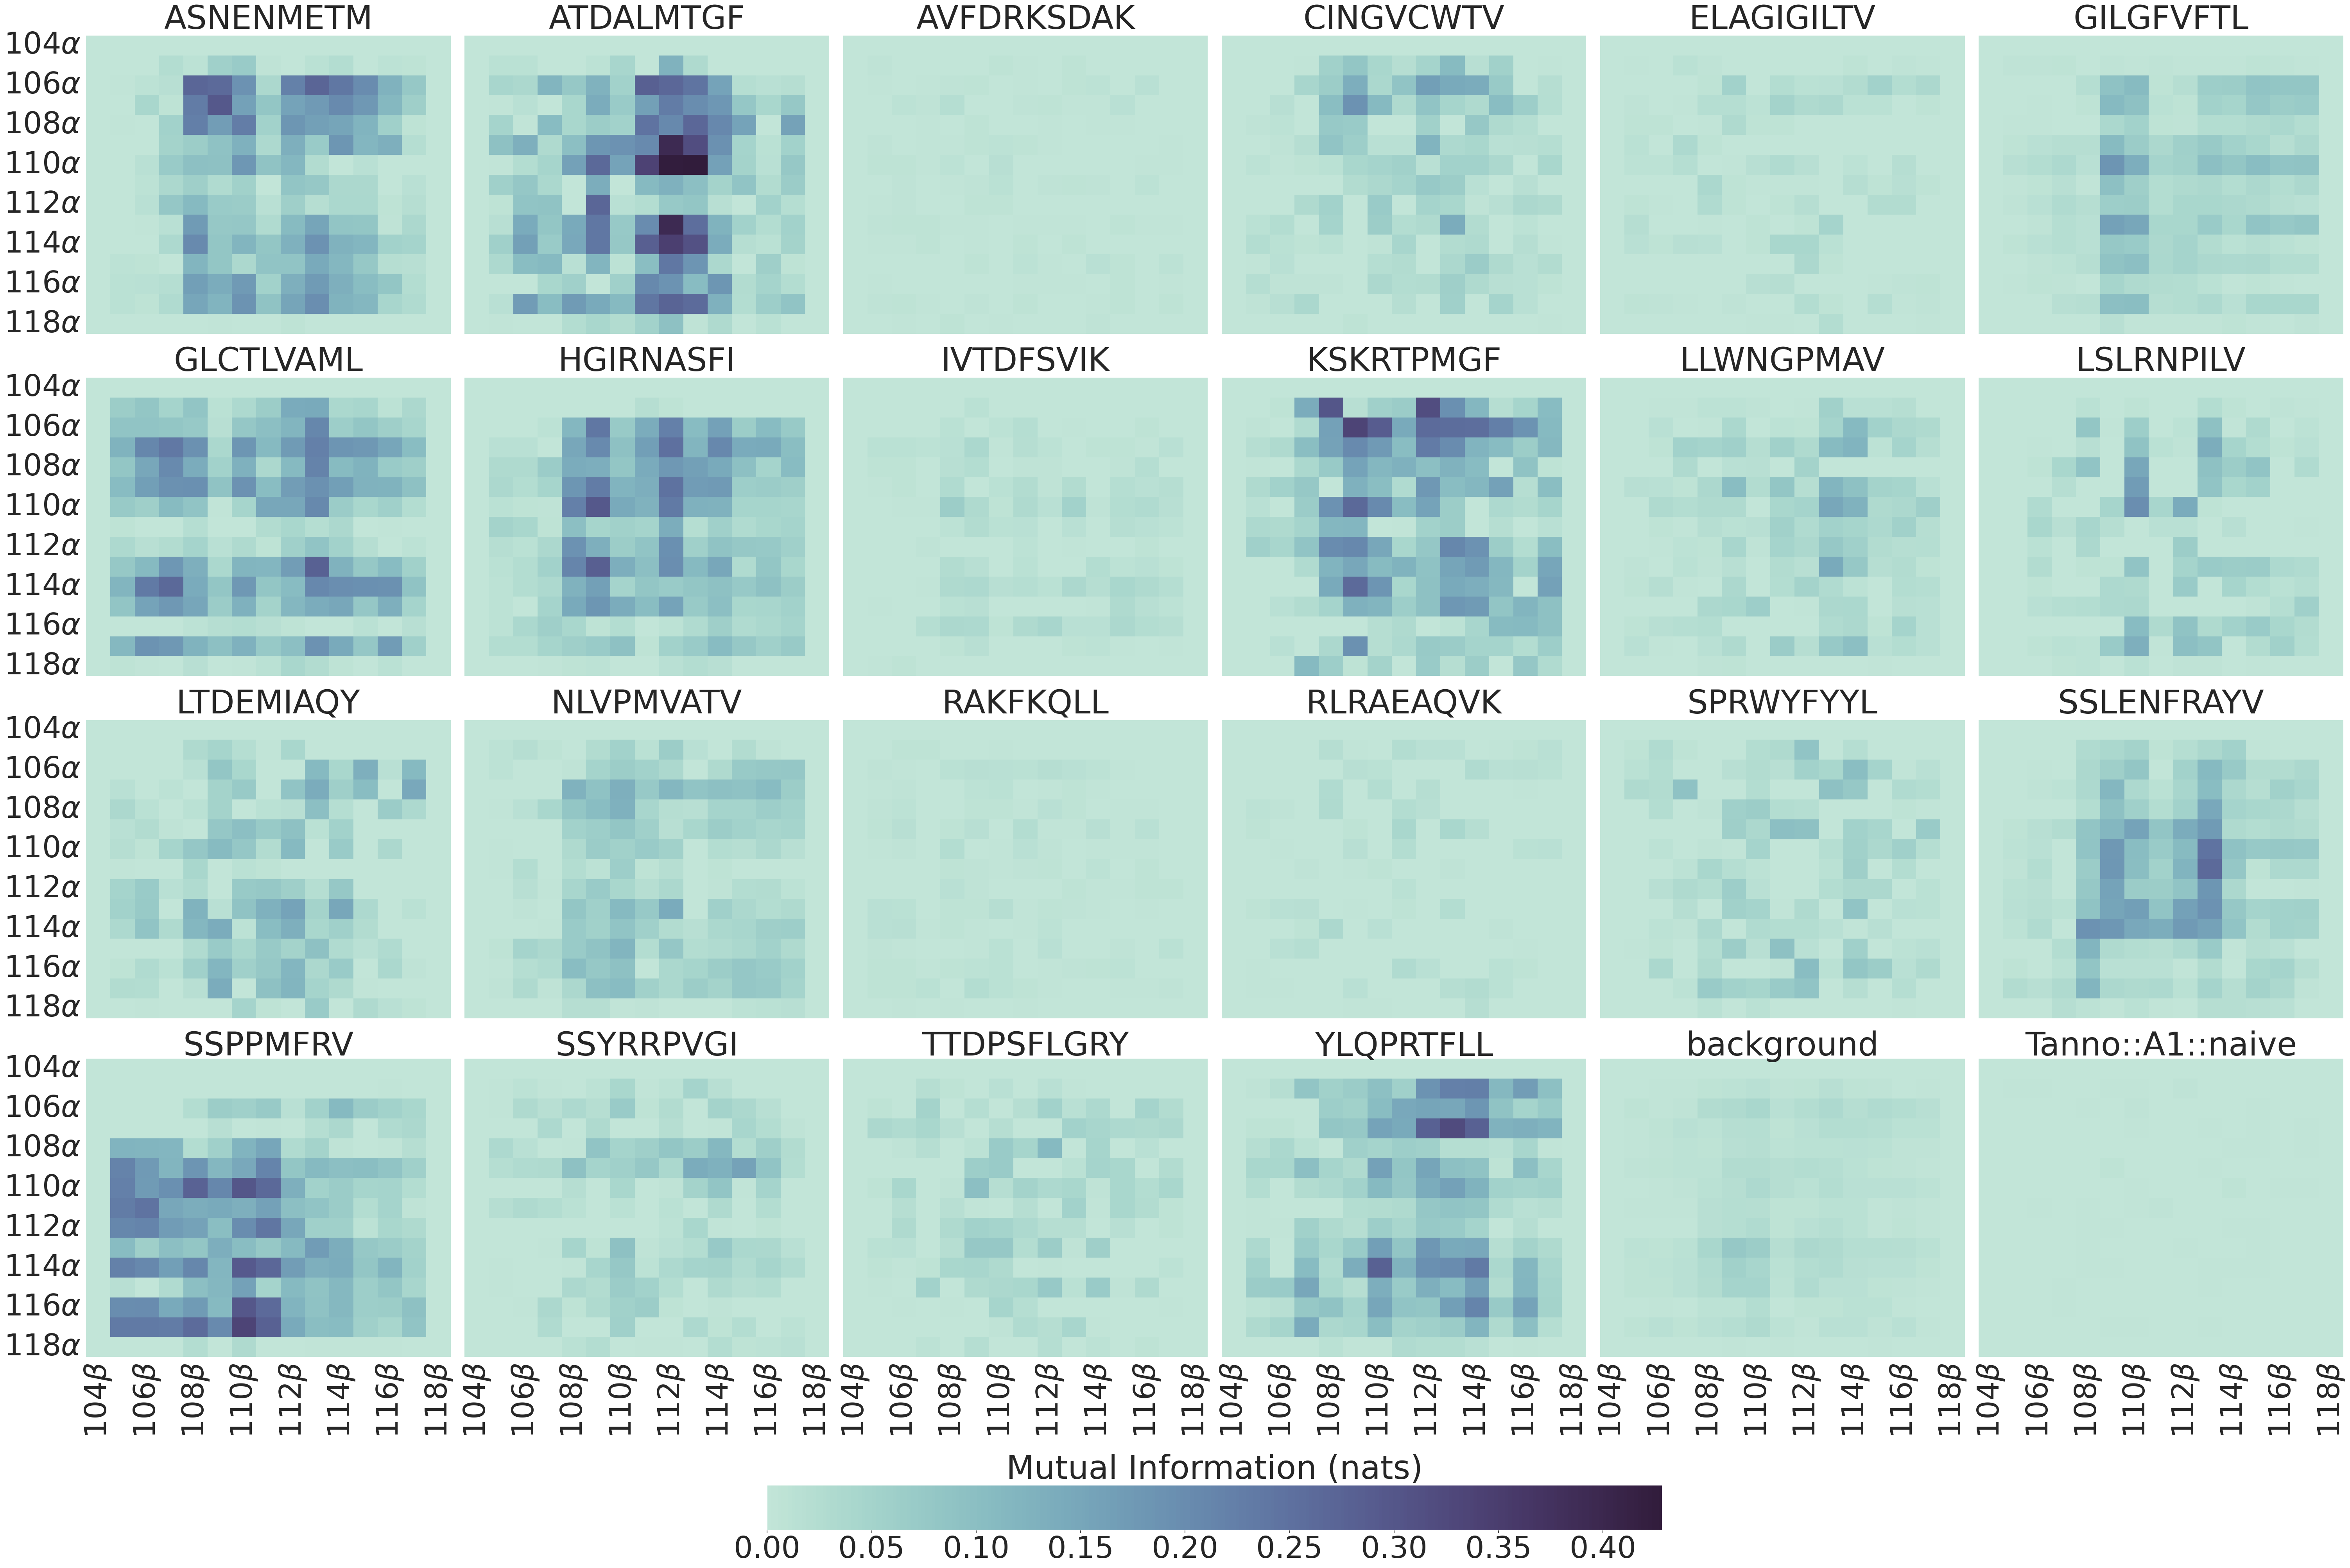

In [10]:
sns.set(font_scale=5)
f, axs = plt.subplots(figsize=(60,40), ncols=6, nrows=4, sharex = 'col', sharey='row', constrained_layout=True)
ax = axs.ravel()

all_epitopes = pd.read_csv('data/output/mutual_info/estimated_mutual_info_all_epitopes_CDR3ab_by_pos_all_epitopes.csv', index_col = 0)
print(all_epitopes)
diffs={}

for x, ep in enumerate(sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']):
    # X = pd.read_csv('data/output/mutual_info/mutual_info_cdr3ab_array_'+ k + '.csv', index_col=0)
    epdf = all_epitopes.loc[all_epitopes['epitope'] == ep]
    diff = epdf.loc[epdf['type'] == 'real'][[c for c in epdf.columns if c not in ['epitope', 'type']]].values - epdf.loc[epdf['type'] == 'shuffle'][[c for c in epdf.columns if c not in ['epitope', 'type']]].values
    X = pd.DataFrame(diff.reshape(19,19))

    X.columns=[str(x) + r'$\beta$' for x in cdr3_res]
    X.index=[str(x) + r'$\alpha$' for x in cdr3_res]
    X = X.drop([r'112.1$\beta$', r'111.1$\beta$', r'112.2$\beta$', r'111.2$\beta$'], axis=1)
    X = X.drop([r'112.1$\alpha$', r'111.1$\alpha$', r'112.2$\alpha$', r'111.2$\alpha$'], axis=0)
    print(np.nanmax(X.values))
    diffs[ep] = X

vmax = np.nanmax([np.nanmax(diffs[x]) for x in diffs])
print(vmax)
for x, ep in enumerate(sorted(vdj['Epitope'].unique().tolist())+ ['background', 'Tanno::A1::naive']):
    m=sns.heatmap(diffs[ep],
                cmap = p, ax = ax[x], cbar=False, vmin=0, vmax=vmax)
    ax[x].set_title(ep)

cbar = f.colorbar(m.get_children()[0], ax=axs[-1,:], orientation="horizontal")
cbar.ax.set_title('Mutual Information (nats)')
plt.savefig('figures/MutualInformation_cdr3a_cdr3b.png')
plt.show()

Is the mutual information related to V gene dominance or public cdr3s?

In [11]:
# # calculate what proportion is the most expanded of each
# top_cdr3a={}
# top_cdr3b={}
# top_Va={}
# top_Vb={}
# # top_Vcdr3a={}
# # top_Vcdr3b={}

# sns.set(font_scale=2)
# for ep in sorted(vdj['Epitope'].unique().tolist()):
#     s = vdj.loc[vdj['Epitope'] == ep]

#     # cdr3

#     top_cdr3a[ep] = s['CDR3-a'].value_counts().max()/s.shape[0]
#     top_cdr3b[ep] = s['CDR3-b'].value_counts().max()/s.shape[0]

#     # V gene
#     top_Va[ep] = s['V-a'].value_counts().max()/s.shape[0]
#     top_Vb[ep] = s['V-b'].value_counts().max()/s.shape[0]

#     # V gene + cdr3
#     s['va-cdr3a'] = s['V-a'] + s['CDR3-a']
#     s['vb-cdr3b'] = s['V-b'] + s['CDR3-b']

#     if ep == 'GLCTLVAML':
#         print(s['V-a'].value_counts())
#         def autopct_generator(limit):
#             # this function is just a hack to only label first slice
#             def inner_autopct(pct):
#                 return ('%.1f' % pct) if pct > limit else ''
#             return inner_autopct
        
#         f, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
#         ax[0,0].pie(s['CDR3-a'].value_counts(), colors=['lightskyblue'],
#                     wedgeprops={'edgecolor':'navy','linewidth': 1},
#                     autopct = autopct_generator(5), radius = 1.2, pctdistance=1.25)
#         ax[0,0].set_title('CDR3a')
#         ax[0,1].pie(s['V-a'].value_counts(), colors=['lightskyblue'], startangle=300,
#                     wedgeprops={'edgecolor':'navy','linewidth': 1},
#                     autopct = autopct_generator(40), radius = 1.2, pctdistance=1.25)
#         ax[0,1].set_title('Va')
#         ax[0,2].pie(s['va-cdr3a'].value_counts(), colors=['lightskyblue'],
#                 wedgeprops={'edgecolor':'navy','linewidth': 1},
#                 autopct = autopct_generator(8), radius = 1.2, pctdistance=1.25)
#         ax[0,2].set_title('Va-CDR3a')

#         ax[1,0].pie(s['CDR3-b'].value_counts(), colors=['salmon'],
#                     wedgeprops={'edgecolor':'darkred','linewidth':1},
#                     autopct = autopct_generator(3), radius = 1.2, pctdistance=1.25)
#         ax[1,0].set_title('CDR3b')
#         ax[1,1].pie(s['V-b'].value_counts(), colors=['salmon'], startangle=330,
#                     wedgeprops={'edgecolor':'darkred','linewidth': 1},
#                     autopct = autopct_generator(20), radius = 1.2, pctdistance=1.25)
#         ax[1,1].set_title('Vb')
#         ax[1,2].pie(s['vb-cdr3b'].value_counts(), colors=['salmon'],
#                     wedgeprops={'edgecolor':'darkred','linewidth': 1},
#                     autopct = autopct_generator(3), radius = 1.2, pctdistance=1.25)
#         ax[1,2].set_title('Vb-CDR3b')

#         f.suptitle(ep)
#         plt.tight_layout()
#         plt.savefig('figures/GLC_pie_charts.png')
#         plt.show()

    

#     # top_Vcdr3a[ep] = s['va-cdr3a'].value_counts().max()/s.shape[0]
#     # top_Vcdr3b[ep] = s['vb-cdr3b'].value_counts().max()/s.shape[0]

In [12]:
# x0 = pd.DataFrame.from_dict(top_Va, orient='index', columns = ['top-Va'])
# x1 = pd.DataFrame.from_dict(top_Vb, orient='index', columns = ['top-Vb'])
# x2 = pd.DataFrame.from_dict(top_cdr3a, orient='index', columns = ['top-cdr3a'])
# x3 = pd.DataFrame.from_dict(top_cdr3b, orient='index', columns = ['top-cdr3b'])
# # x4 = pd.DataFrame.from_dict(top_Vcdr3a, orient='index', columns = ['top-Vcdr3a'])
# # x5 = pd.DataFrame.from_dict(top_Vcdr3b, orient='index', columns = ['top-Vcdr3b'])

# x = pd.merge(x0,x2, left_index=True, right_index=True)
# # x = pd.merge(x,x4, left_index=True, right_index=True)
# x = pd.merge(x,x1, left_index=True, right_index=True)
# x = pd.merge(x,x3, left_index=True, right_index=True)
# # x = pd.merge(x,x5, left_index=True, right_index=True)

# publicity = x.copy()
# print(publicity)

In [13]:
MIdf=pd.DataFrame()
for ep in corrected_matrices.keys():
    MIdf.loc[ep, 'cdr3a-cdr3b MI'] = corrected_matrices[ep].loc['CDR3b', 'CDR3a']
    MIdf.loc[ep, 'Va-cdr3a MI'] = corrected_matrices[ep].loc['CDR3a', 'Va']
    MIdf.loc[ep, 'Vb-cdr3b MI'] = corrected_matrices[ep].loc['CDR3b', 'Vb']

print(MIdf)

                  cdr3a-cdr3b MI  Va-cdr3a MI  Vb-cdr3b MI
ELAGIGILTV              0.881321     1.537221     1.486100
GILGFVFTL               7.678114     5.519451     3.012862
NLVPMVATV               7.560614     4.087838     2.881633
GLCTLVAML              17.088626     5.427702     7.063645
SSLENFRAYV              9.847345     5.030712     3.040888
ASNENMETM              14.120535     3.380775     5.308489
YLQPRTFLL              14.930568     4.411901     3.762941
LLWNGPMAV               5.370476     3.531910     2.450704
CINGVCWTV               6.054008     3.682984     2.285154
KSKRTPMGF              16.418794     3.643423     5.114723
ATDALMTGF              20.246229     6.155680     4.956654
AVFDRKSDAK              0.355122     2.901457     1.740345
IVTDFSVIK               1.221112     5.449357     4.474466
RAKFKQLL                0.632176     6.050642     4.687009
RLRAEAQVK              -0.242222     2.651857     1.406543
HGIRNASFI              14.143200     4.801677     4.4710

In [14]:
import statsmodels.api as sm


def simple_regplot(x_name,
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    print(fit_results.summary())
    pval = fit_results.f_pvalue
    Rsq = fit_results.rsquared
    Rsq_adj = fit_results.rsquared_adj
    if (pval<0.05):
        line_kws={'color':'red'}
        ci_kws={'color':'red'}
    else:
        line_kws={'color':'k'}
        ci_kws={'color':'k'}

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and 95% CI
    ci_kws = {} if ci_kws is None else ci_kws
    df_predictions = pred.summary_frame(alpha=0.05)
    ax.fill_between(
        eval_x[:, 1],
        df_predictions.mean_ci_lower,
        df_predictions.mean_ci_upper,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color())#, **scatter_kws)

    return pval, Rsq, Rsq_adj

In [15]:
# X = pd.merge(MIdf, publicity, left_index=True, right_index=True)

# f, ax = plt.subplots(nrows=3, ncols = 4, figsize=(15,10), sharex='col', sharey='row')

# sns.set()
# sns.set(font_scale=1.2)
# for j, c1 in enumerate(MIdf.columns):
#     for i, c2 in enumerate(publicity.columns):
#         # if (c1 == 'Va-cdr3a MI') and ((c2 == 'top-cdr3a') | (c2 == 'top-Vcdr3a')):
#         #     col='red'
#         # elif (c1 == 'Vb-cdr3b MI') and ((c2 == 'top-cdr3b') | (c2 == 'top-Vcdr3b')):
#         #     col='red'
#         # else:
#         #     col='k'
#         # sns.scatterplot(data = X, x =c2, y = c1, s=50, ax=ax[j,i], color=col)
#         # sns.regplot(data = X, x =c2, y = c1, ax=ax[j,i], color=col, logx=True, x_ci=95)
#         pval,Rsq = simple_regplot(c2, np.log10(X[c2]), X[c1], ax=ax[j,i])
        
#         ax[j,i].annotate('pval = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(2)),(0,1), xycoords='axes fraction')
#         if i == 0:
#             ax[j,i].set_ylabel(c1)
#         if j == 2:
#             ax[j,i].set_xlabel(c2 + r' (log$_{10}$)')
#         # ax[j,i].set_xscale('log')
# plt.tight_layout()
# plt.savefig('figures/MutualInformation_vs_diversity_corr.png')
# plt.show()

I want to correlate CDR3a/b and V/cdr3 MI with SASA

In [16]:
# manually calculated SASA with pymol
sasa  = {
    'RAKFKQLL':243,
    'NLVPMVATV':375,
    'GLCTLVAML':341,
    'SSLENFRAYV':464,
    'YLQPRTFLL':460,
    'LLWNGPMAV':307,
    'ELAGIGILTV':329,
    'CINGVCWTV':264,
    'LSLRNPILV':308,
    'SSYRRPVGI':331,
    'SPRWYFYYL':436,
    'GILGFVFTL':259, 
    'ASNENMETM':311
}
sasa = pd.Series(sasa)
print(sasa)

RAKFKQLL      243
NLVPMVATV     375
GLCTLVAML     341
SSLENFRAYV    464
YLQPRTFLL     460
LLWNGPMAV     307
ELAGIGILTV    329
CINGVCWTV     264
LSLRNPILV     308
SSYRRPVGI     331
SPRWYFYYL     436
GILGFVFTL     259
ASNENMETM     311
dtype: int64


In [17]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures


def simple_regplot_parabola(x_name, y_name, df,
        n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    formula = y_name + ' ~ ' + x_name + ' + I(' + x_name + '**2)'
    fit_results = smf.ols(formula, data=df).fit()

    print(fit_results.summary())
    pval = fit_results.f_pvalue
    Rsq = fit_results.rsquared
    Rsq_adj = fit_results.rsquared_adj
    print('pval, Rsq:', pval, Rsq)
    if pval<0.05:
        line_kws={'color':'red'}
        ci_kws={'color':'red'}
    else:
        line_kws={'color':'k'}
        ci_kws={'color':'k'}

    eval_x = pd.DataFrame(np.linspace(np.min(df[x_name]), np.max(df[x_name]), n_pts), columns=['sasa'])
    # print(eval_x)
    pred = fit_results.get_prediction(eval_x, transform=True)
    # print(pred.predicted_mean)

    # draw the fit line and 95% CI
    ci_kws = {} if ci_kws is None else ci_kws
    df_predictions = pred.summary_frame(alpha=0.05)
    ax.fill_between(
        eval_x['sasa'],
        df_predictions.mean_ci_lower,
        df_predictions.mean_ci_upper,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x['sasa'], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(df[x_name], df[y_name], c=h[0].get_color())#, **scatter_kws)

    return pval, Rsq, Rsq_adj

cdr3a-cdr3b MI
                            OLS Regression Results                            
Dep. Variable:         cdr3a_cdr3b_MI   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.7903
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.480
Time:                        23:19:49   Log-Likelihood:                -38.748
No. Observations:                  13   AIC:                             83.50
Df Residuals:                      10   BIC:                             85.19
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.0339     41.45

/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/marti/miniconda3/envs/MutualInformation/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


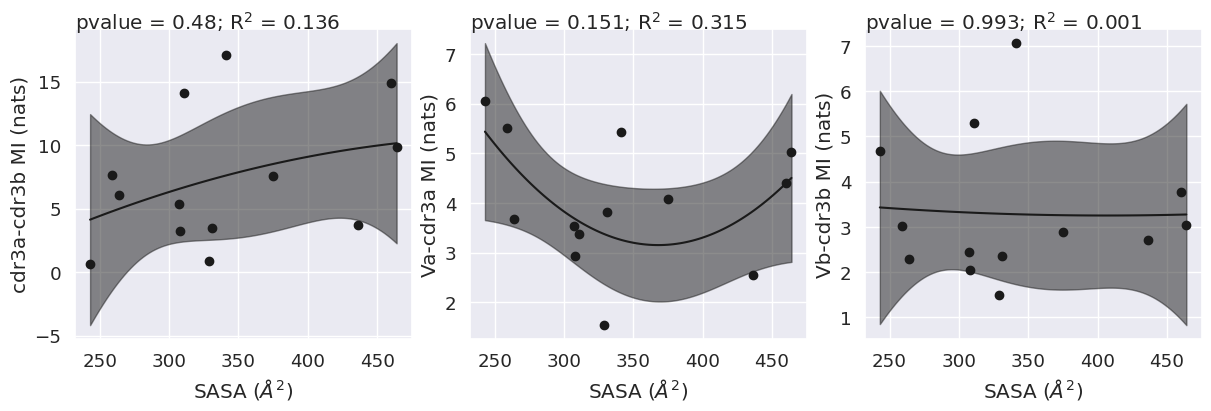

In [18]:
X1 = pd.merge(MIdf, pd.DataFrame(sasa, columns=['sasa']), left_index=True, right_index=True)
X1.columns = [x.replace('-','_').replace(' ','_') for x in X1.columns]

sns.set(font_scale=1.2)
f, ax = plt.subplots(nrows=1, ncols = 3, figsize=(12,4), sharex='col', constrained_layout=True)

for j, c1 in enumerate(MIdf.columns):
    print(c1)
    pval,Rsq, Rsq_adj = simple_regplot_parabola('sasa', c1.replace('-','_').replace(' ','_'), X1, ax=ax[j])
    ax[j].annotate('pvalue = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(3)),(0,1), xycoords='axes fraction')
    ax[j].set_xlabel(r'SASA ($\AA^2$)')
    ax[j].set_ylabel(c1 + ' (nats)')
plt.savefig('figures/MutualInformation_vs_sasa_corr.png')
plt.show()

In [19]:
# f, ax = plt.subplots(nrows=1, ncols = 4, figsize=(16,4), sharex='col', constrained_layout=True)
# # ax = axs.ravel()

# sns.set(font_scale=1.2)
# for j, c1 in enumerate(publicity.columns):
#     pval,Rsq = simple_regplot_parabola('sasa', c1.replace('-','_').replace(' ','_'), X1, ax=ax[j])
#     ax[j].annotate('pval = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(2)),(0,1), xycoords='axes fraction')
#     ax[j].set_xlabel('sasa')
#     ax[j].set_ylabel(c1)

# plt.savefig('figures/publicity_vs_sasa_corr.png')
# plt.show()

In [20]:
from Levenshtein import distance as lev

In [21]:
# calculate effective set size
# effective_set_size = []

# for ep in sorted(vdj['Epitope'].unique().tolist()):
#     epset = vdj.loc[vdj['Epitope'] == ep]
#     ess_a = sum([1/len([y for y in epset['CDR3-a'].tolist() if lev(x,y) < 2]) for x in epset['CDR3-a'].tolist()])/epset.shape[0]
#     ess_b = sum([1/len([y for y in epset['CDR3-b'].tolist() if lev(x,y) < 2]) for x in epset['CDR3-b'].tolist()])/epset.shape[0]
#     ab = (epset['CDR3-a'] + epset['CDR3-b']).tolist()
#     ess_ab = sum([1/len([y for y in ab if lev(x,y) < 3]) for x in ab])/epset.shape[0]
#     print(ep, ess_ab, len(ab))
#     effective_set_size.append((ep, ess_a, ess_b, ess_ab, len(ab)))

In [22]:
vdj.head()

,Unnamed: 0,complex.id,Gene-a,CDR3-a,V-a,J-a,Species,MHC A,MHC B,MHC class,...,cdr2a_IMGTgaps,cdr2b_IMGTgaps,cdr3a_IMGTgaps,cdr3b_IMGTgaps,len_cdr3a,len_cdr3b,len_cdr3a_IMGTgaps,cdr3a_IMGTgaps_padded,len_cdr3b_IMGTgaps,cdr3b_IMGTgaps_padded
0,13,14,TRA,CAYTVLGNEKLTF,TRAV38-1,TRAJ48,HomoSapiens,HLA-A*02,B2M,MHCI,...,QEAY--KQQN,SYD----VKM,CAYTVLG--NEKLTF,CASSFTP--YNEQFF,15,15,15,"C, A, Y, T, V, L, G, -, -, -, -, -, -, N, E, K...",15,"C, A, S, S, F, T, P, -, -, -, -, -, -, Y, N, E..."
1,14,15,TRA,CAVAGYGGSQGNLIF,TRAV12-2,TRAJ42,HomoSapiens,HLA-A*02,B2M,MHCI,...,IYS----NGD,SYD----VKM,CAVAGYGGSQGNLIF,CASSPQG-LGTEAFF,15,15,15,"C, A, V, A, G, Y, G, G, -, -, -, -, S, Q, G, N...",15,"C, A, S, S, P, Q, G, -, -, -, -, -, L, G, T, E..."
2,15,16,TRA,CAVSFGNEKLTF,TRAV12-2,TRAJ48,HomoSapiens,HLA-A*02,B2M,MHCI,...,IYS----NGD,SYD----VKM,CAVSFG---NEKLTF,CAEGQGF-VGQPQHF,15,15,15,"C, A, V, S, F, G, -, -, -, -, -, -, -, N, E, K...",15,"C, A, E, G, Q, G, F, -, -, -, -, -, V, G, Q, P..."
3,16,17,TRA,CAVTHYGGSQGNLIF,TRAV12-2,TRAJ42,HomoSapiens,HLA-A*02,B2M,MHCI,...,IYS----NGD,SYD----VKM,CAVTHYGGSQGNLIF,CASLRSAVWADTQYF,15,15,15,"C, A, V, T, H, Y, G, G, -, -, -, -, S, Q, G, N...",15,"C, A, S, L, R, S, A, V, -, -, -, -, W, A, D, T..."
4,17,18,TRA,CAGGGGGADGLTF,TRAV12-2,TRAJ45,HomoSapiens,HLA-A*02,B2M,MHCI,...,IYS----NGD,SYD----VKM,CAGGGGG--ADGLTF,CASTLTG-LGQPQHF,15,15,15,"C, A, G, G, G, G, G, -, -, -, -, -, -, A, D, G...",15,"C, A, S, T, L, T, G, -, -, -, -, -, L, G, Q, P..."


In [23]:
from scipy.spatial.distance import hamming

In [24]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1)
        print(s2)
        raise ValueError("Strand lengths are not equal!")
    return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))

In [25]:
# calculate effective set size
effective_set_size = []

for ep in sorted(vdj['Epitope'].unique().tolist()):
    epset = vdj.loc[vdj['Epitope'] == ep]
    ess_a = sum([1/len([y for y in epset['cdr3a_IMGTgaps_padded'].tolist() if hamming_distance(x.split(','),y.split(',')) < 2]) for x in epset['cdr3a_IMGTgaps_padded'].tolist()])/epset.shape[0]
    ess_b = sum([1/len([y for y in epset['cdr3b_IMGTgaps_padded'].tolist() if hamming_distance(x.split(','),y.split(',')) < 2]) for x in epset['cdr3b_IMGTgaps_padded'].tolist()])/epset.shape[0]
    ab = (epset['cdr3a_IMGTgaps_padded'] + epset['cdr3b_IMGTgaps_padded']).tolist()
    ess_ab = sum([1/len([y for y in ab if hamming_distance(x.split(','),y.split(',')) < 3]) for x in ab])/epset.shape[0]
    print(ep, ess_ab, len(ab))
    effective_set_size.append((ep, ess_a, ess_b, ess_ab, len(ab)))

ASNENMETM 0.7130855552646995 187
ATDALMTGF 0.8726287262872628 123
AVFDRKSDAK 0.9935872642170464 1699
CINGVCWTV 0.9867256637168141 226
ELAGIGILTV 0.9947368421052631 380
GILGFVFTL 0.6800932591890875 1853
GLCTLVAML 0.7788164338091453 343
HGIRNASFI 0.7695767195767199 240
IVTDFSVIK 0.9753551136363636 704
KSKRTPMGF 0.8722222222222222 90
LLWNGPMAV 0.9609929078014183 235
LSLRNPILV 0.8920134983127109 127
LTDEMIAQY 0.9596774193548387 124
NLVPMVATV 0.8941049507621743 353
RAKFKQLL 0.9279268778641165 1195
RLRAEAQVK 1.0 412
SPRWYFYYL 0.9885714285714285 175
SSLENFRAYV 0.7881100620324757 348
SSPPMFRV 0.5649874990506573 125
SSYRRPVGI 0.8917675544794189 177
TTDPSFLGRY 0.9765840220385675 242
YLQPRTFLL 0.9073835740502406 333


In [26]:
effective_set_size = pd.DataFrame(effective_set_size, columns=['epitope','effective_set_size_a','effective_set_size_b','effective_set_size','N'])

In [27]:
effective_set_size

,epitope,effective_set_size_a,effective_set_size_b,effective_set_size,N
0,ASNENMETM,0.660446,0.448302,0.713086,187
1,ATDALMTGF,0.655453,0.813008,0.872629,123
2,AVFDRKSDAK,0.823946,0.908858,0.993587,1699
3,CINGVCWTV,0.878371,0.913274,0.986726,226
4,ELAGIGILTV,0.728912,0.908070,0.994737,380
5,GILGFVFTL,0.402302,0.363130,0.680093,1853
6,GLCTLVAML,0.524611,0.534546,0.778816,343
7,HGIRNASFI,0.556202,0.524706,0.769577,240
8,IVTDFSVIK,0.713123,0.731534,0.975355,704
9,KSKRTPMGF,0.855556,0.685926,0.872222,90


In [28]:
X2 = pd.merge(effective_set_size, MIdf, right_index=True, left_on='epitope')

                            OLS Regression Results                            
Dep. Variable:         cdr3a-cdr3b MI   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     3.139
Date:                Mon, 20 May 2024   Prob (F-statistic):             0.0917
Time:                        23:21:00   Log-Likelihood:                -70.998
No. Observations:                  22   AIC:                             146.0
Df Residuals:                      20   BIC:                             148.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2129      1.844      5.537      0.0

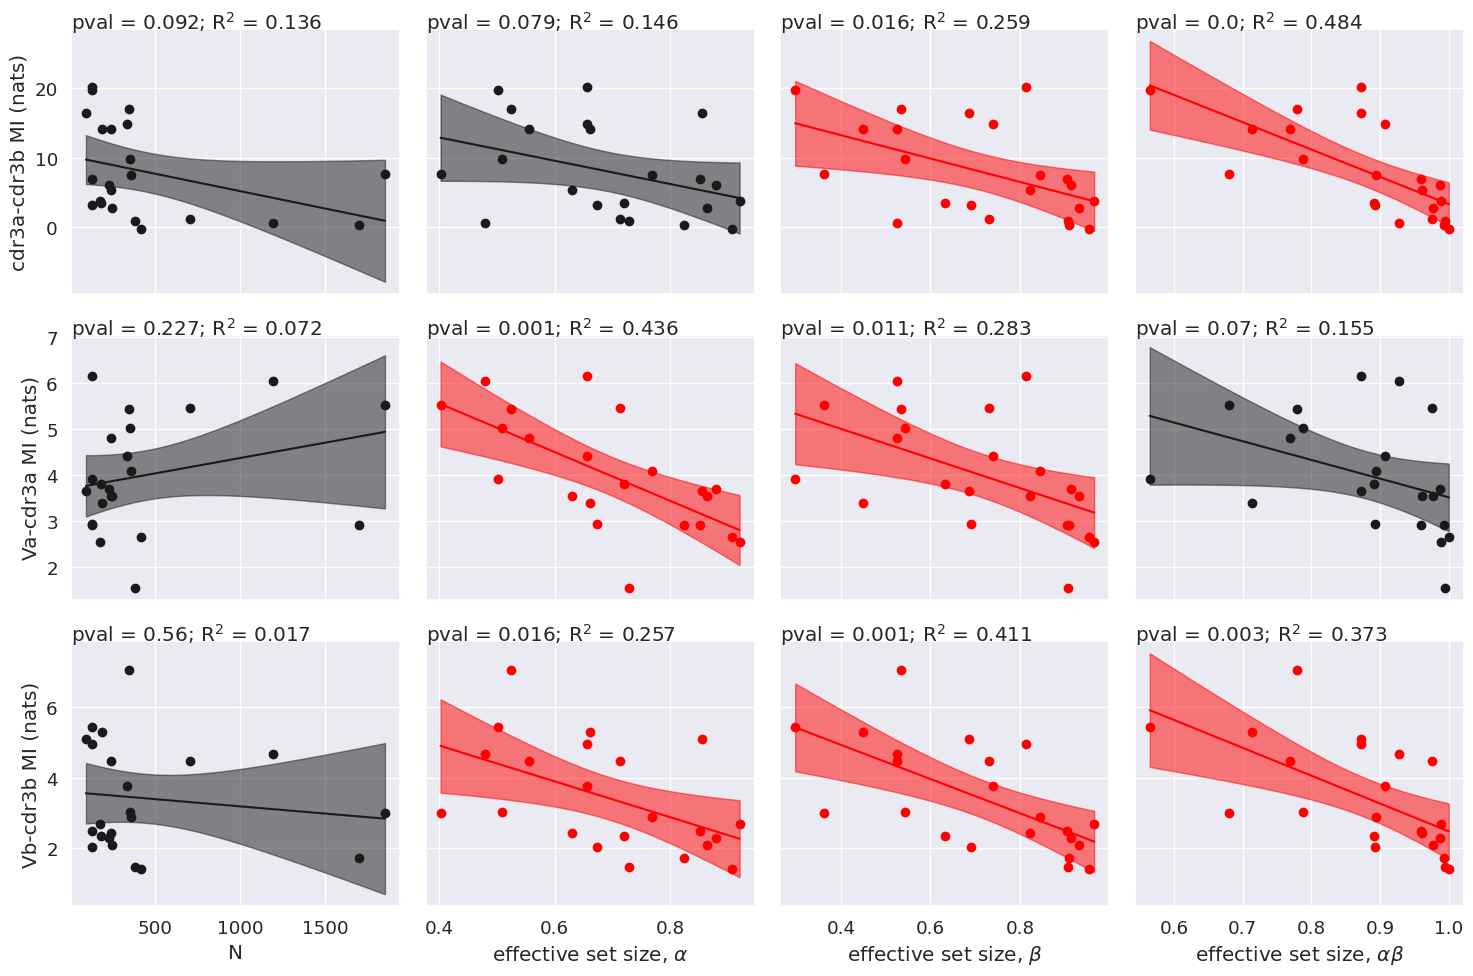

In [29]:
labels = {'effective_set_size_a':r'effective set size, $\alpha$',
          'effective_set_size_b':r'effective set size, $\beta$',
          'effective_set_size':r'effective set size, $\alpha\beta$',
          'N':'N'}

sns.set(font_scale=1.2)
f, ax = plt.subplots(nrows=3, ncols = 4, figsize=(15,10), sharex='col', sharey='row')
for i, c2 in enumerate(['N','effective_set_size_a', 'effective_set_size_b', 'effective_set_size']):
    for j, c1 in enumerate(MIdf.columns):
        # if (c1 == 'Va-cdr3a MI') and ((c2 == 'top-cdr3a') | (c2 == 'top-Vcdr3a')):
        #     col='red'
        # elif (c1 == 'Vb-cdr3b MI') and ((c2 == 'top-cdr3b') | (c2 == 'top-Vcdr3b')):
        #     col='red'
        # else:
        #     col='k'
        # sns.scatterplot(data = X, x =c2, y = c1, s=50, ax=ax[j,i], color=col)
        # sns.regplot(data = X, x =c2, y = c1, ax=ax[j,i], color=col, logx=True, x_ci=95)
        pval,Rsq, Rsq_adj = simple_regplot(c2, X2[c2], X2[c1], ax=ax[j,i])
        
        
        ax[j,i].annotate('pval = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(3)),(0,1), xycoords='axes fraction')
        if i == 0:
            ax[j,i].set_ylabel(c1 + ' (nats)')
        if j == 2:
            ax[j,i].set_xlabel(labels[c2])
        # ax[j,i].set_xscale('log')
plt.tight_layout()
plt.savefig('figures/MutualInformation_vs_effective_set_size.png')
plt.show()

In [30]:
MIdf.columns

Index(['cdr3a-cdr3b MI', 'Va-cdr3a MI', 'Vb-cdr3b MI'], dtype='object')

0         Ja-CDR3a
1         Ja-CDR3b
2            Ja-Jb
3         Jb-CDR3a
4         Jb-CDR3b
          ...     
355       Vb-CDR3a
356       Vb-CDR3b
357          Vb-Ja
358          Vb-Jb
359    CDR3a-CDR3b
Name: pair, Length: 360, dtype: object
Ja-CDR3a
                            OLS Regression Results                            
Dep. Variable:                real_MI   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     5.965
Date:                Mon, 20 May 2024   Prob (F-statistic):             0.0240
Time:                        23:21:02   Log-Likelihood:                -32.991
No. Observations:                  22   AIC:                             69.98
Df Residuals:                      20   BIC:                             72.16
Df Model:                           1                                         
Covariance Type:            nonr

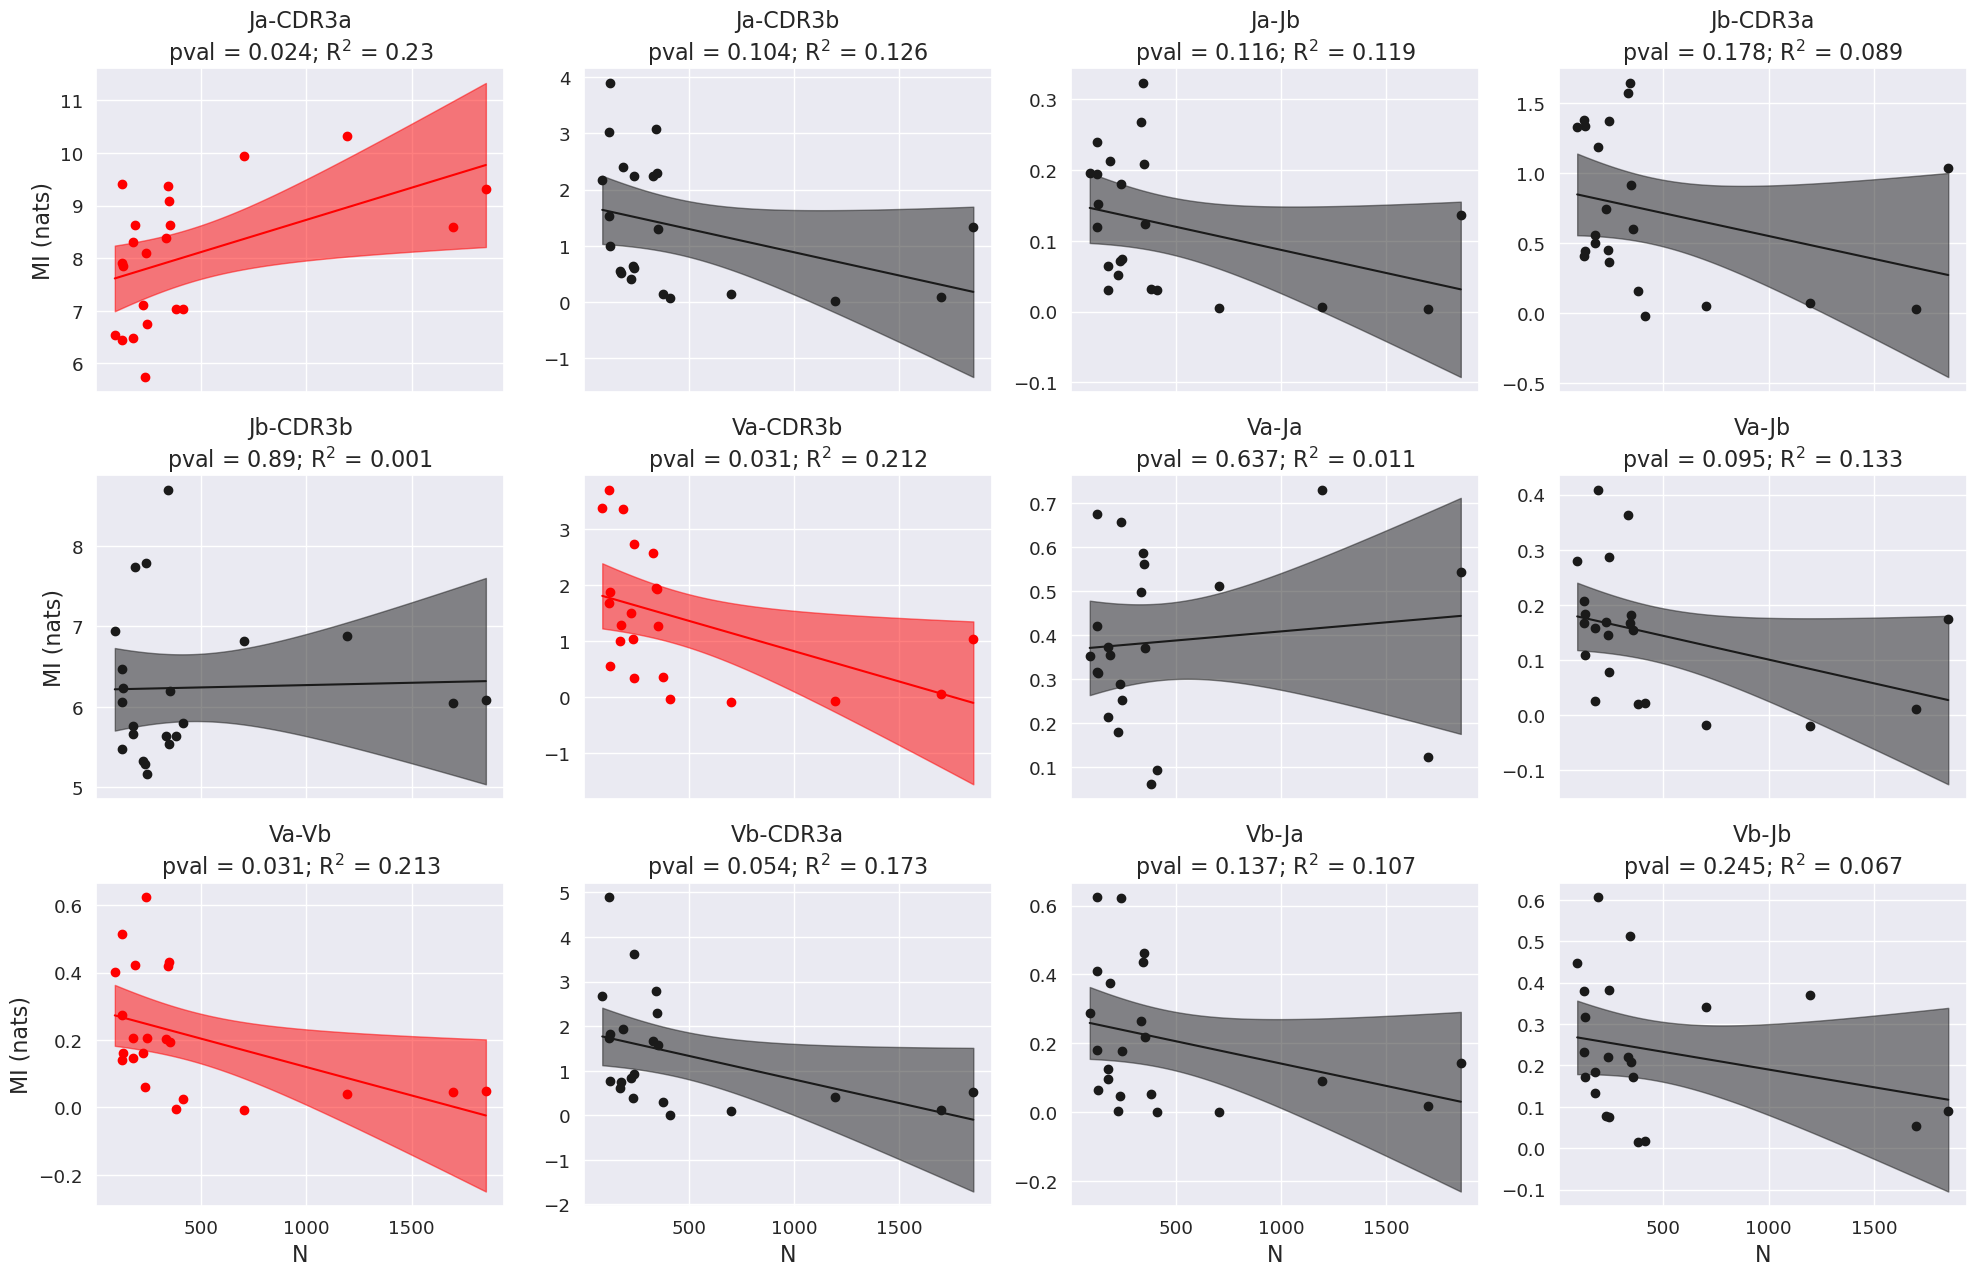

In [31]:
estimatedMI['pair'] = estimatedMI['var1'] + '-' + estimatedMI['var2']
print(estimatedMI['pair'])

fig, axs = plt.subplots(ncols=4, nrows=3, figsize = (20,13), sharex = True)
ax = axs.ravel()
i = 0

for pair in estimatedMI['pair'].unique():
    if pair not in ['CDR3a-CDR3b', 'Va-CDR3a', 'Vb-CDR3b']:
        print(pair)
        p = estimatedMI.loc[estimatedMI['pair'] == pair]
        p = pd.merge(p, effective_set_size)
        c1 = 'real_MI'
        c2 = 'N'
        pval,Rsq,Rsq_adj = simple_regplot(c2, p[c2], p[c1], ax=ax[i])
        # ax[i].annotate(pair + r'; R$^2$ = ' + str(Rsq.round(2)) + '; pval = ' + str(pval.round(3)),(0,1), xycoords='axes fraction', fontsize=16)
        ax[i].set_title(pair + '\n' + 'pval = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(3)) , fontsize=16)
        if i%4 == 0:
            ax[i].set_ylabel('MI (nats)', fontsize=16)
        if i >7 :
            ax[i].set_xlabel('N', fontsize=16)
        # ax[j,i].set_xscale('log')
        i+=1
plt.tight_layout()
plt.savefig('figures/MutualInformation_vs_N.png')
plt.show()

Ja-CDR3a
                            OLS Regression Results                            
Dep. Variable:                real_MI   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.875
Date:                Mon, 20 May 2024   Prob (F-statistic):              0.105
Time:                        23:21:05   Log-Likelihood:                -34.384
No. Observations:                  22   AIC:                             72.77
Df Residuals:                      20   BIC:                             74.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.36

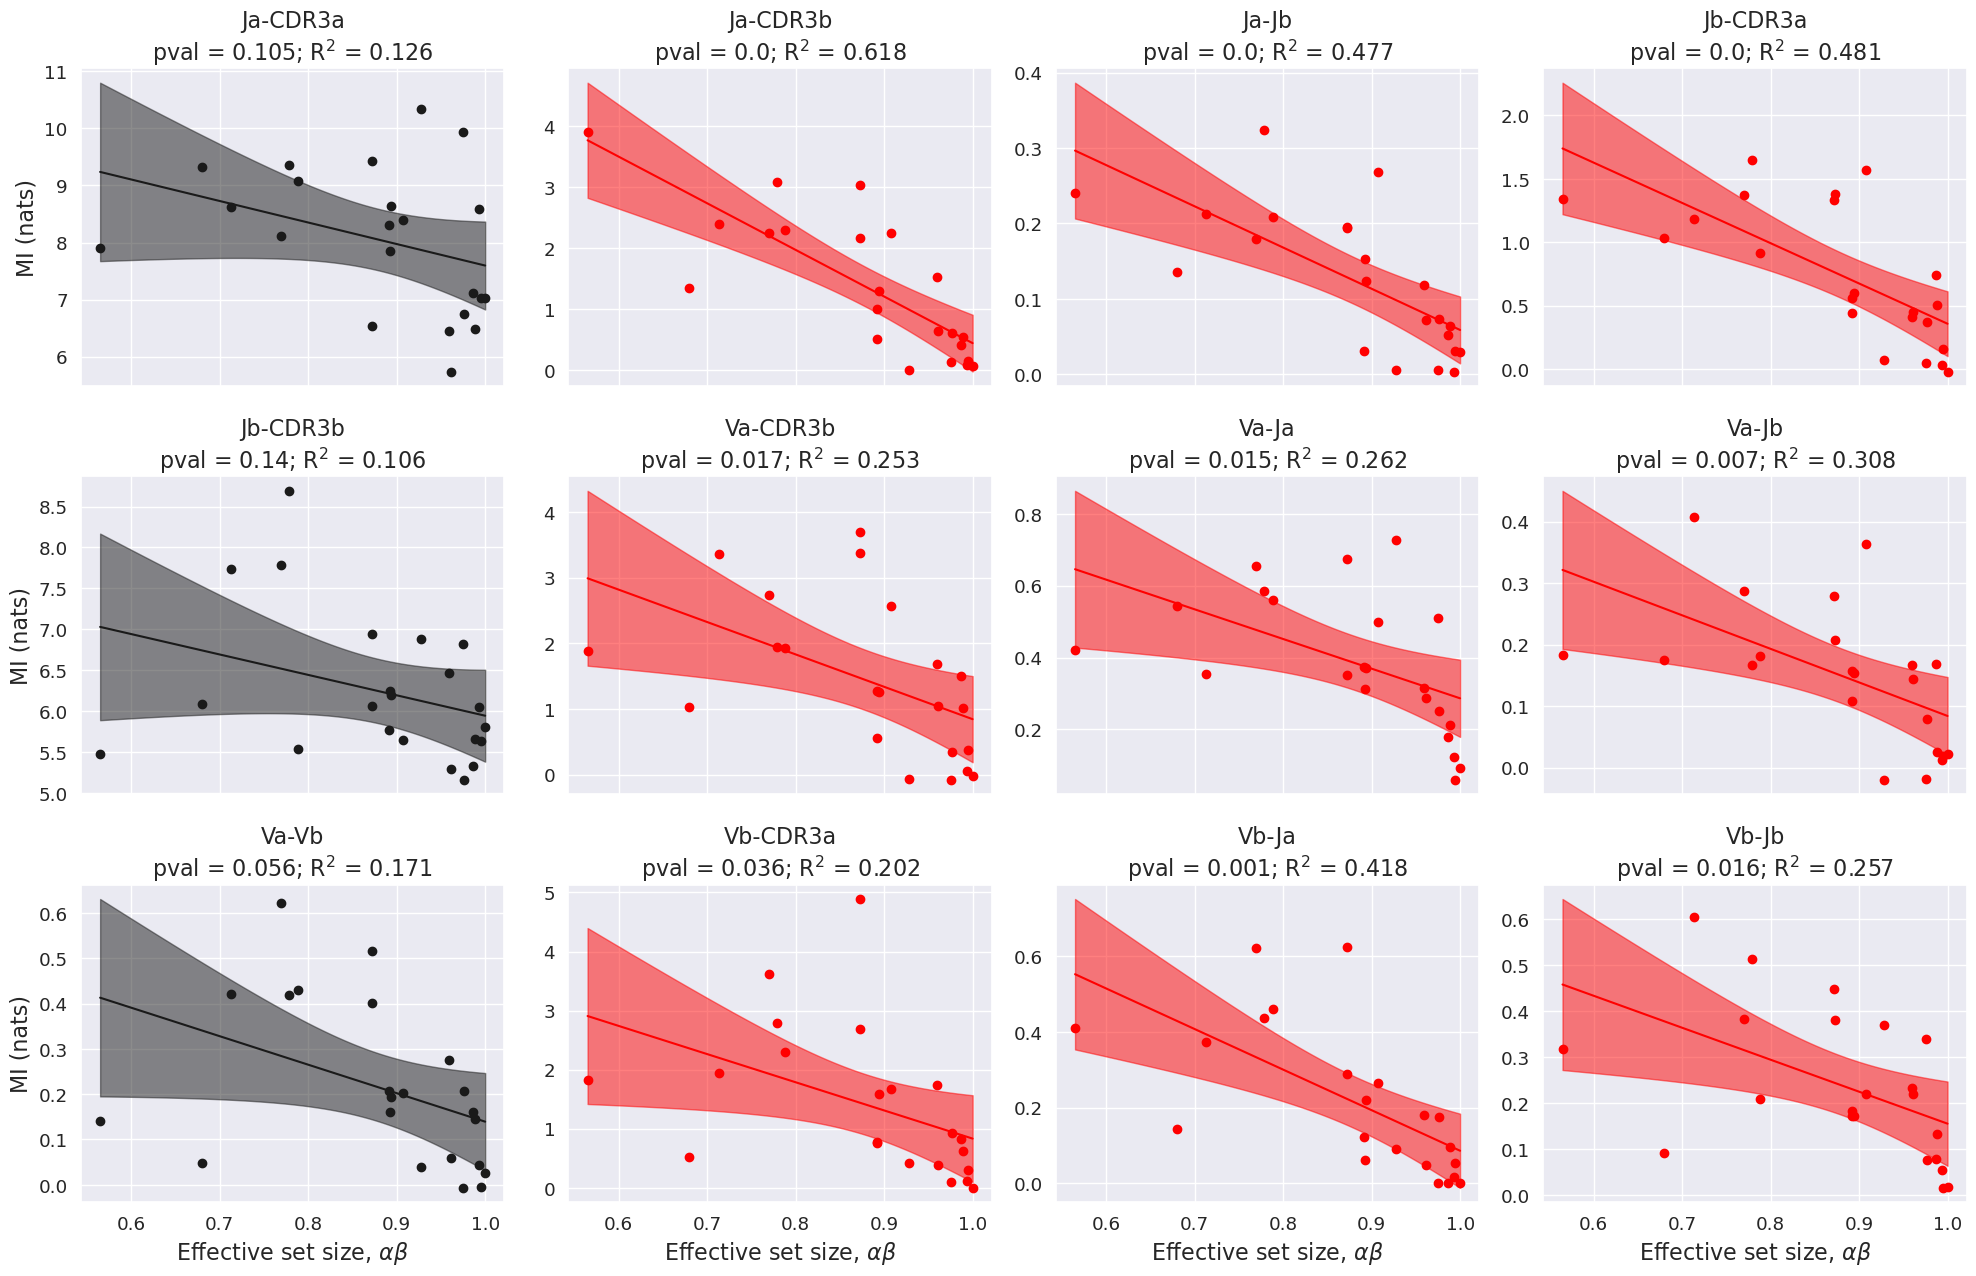

In [32]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize = (20,13), sharex = True)
ax = axs.ravel()
i=0

for pair in estimatedMI['pair'].unique():
    if pair not in ['CDR3a-CDR3b', 'Va-CDR3a', 'Vb-CDR3b']:
        print(pair)
        p = estimatedMI.loc[estimatedMI['pair'] == pair]
        p = pd.merge(p, effective_set_size)
        c1 = 'real_MI'
        c2 = 'effective_set_size'
        pval,Rsq,R_adj = simple_regplot(c2, p[c2], p[c1], ax=ax[i])
        ax[i].set_title(pair + '\n' + 'pval = ' + str(pval.round(3)) + r'; R$^2$ = ' + str(Rsq.round(3)) , fontsize=16)
        if i%4 == 0:
            ax[i].set_ylabel('MI (nats)', fontsize=16)
        if i >7 :
            ax[i].set_xlabel(r'Effective set size, $\alpha\beta$', fontsize=16)
        # ax[j,i].set_xscale('log')
        i+=1
plt.tight_layout()
plt.savefig('figures/MutualInformation_vs_effective_set_size_all.png')
plt.show()

In [33]:
effective_set_size.head()

,epitope,effective_set_size_a,effective_set_size_b,effective_set_size,N
0,ASNENMETM,0.660446,0.448302,0.713086,187
1,ATDALMTGF,0.655453,0.813008,0.872629,123
2,AVFDRKSDAK,0.823946,0.908858,0.993587,1699
3,CINGVCWTV,0.878371,0.913274,0.986726,226
4,ELAGIGILTV,0.728912,0.908070,0.994737,380


(22, 5)
                             OLS Regression Results                             
Dep. Variable:     effective_set_size_a   R-squared:                       0.099
Model:                              OLS   Adj. R-squared:                  0.053
Method:                   Least Squares   F-statistic:                     2.186
Date:                  Mon, 20 May 2024   Prob (F-statistic):              0.155
Time:                          23:21:08   Log-Likelihood:                 11.698
No. Observations:                    22   AIC:                            -19.40
Df Residuals:                        20   BIC:                            -17.21
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7372   

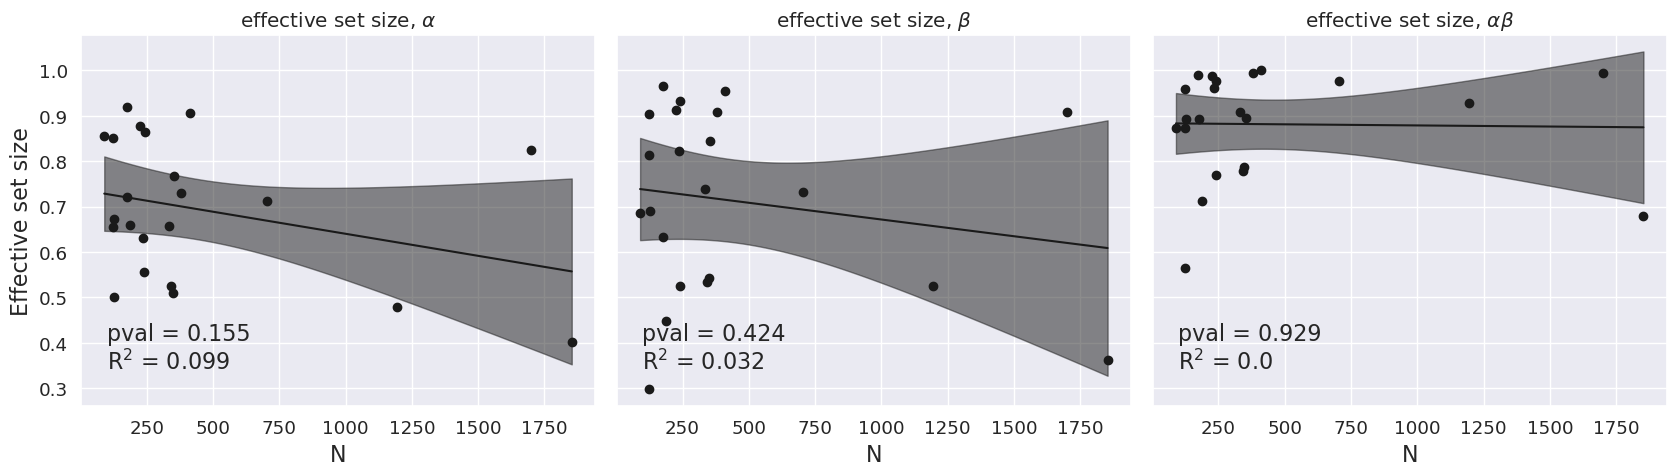

In [34]:
p = effective_set_size[['effective_set_size_a', 'effective_set_size_b', 'effective_set_size', 'N', 'epitope']].drop_duplicates()
print(p.shape)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (17,5), sharex = True, sharey=True)
ax = axs.ravel()

for i,c1 in enumerate(['effective_set_size_a', 'effective_set_size_b', 'effective_set_size']):

    c2 = 'N'
    pval,Rsq,R_adj = simple_regplot(c2, p[c2], p[c1], ax=ax[i])
    ax[i].annotate('pval = ' + str(pval.round(3)) + '\n' + r'R$^2$ = ' + str(Rsq.round(3)),(0.05,.1), xycoords='axes fraction',fontsize=16)
    ax[i].set_xlabel('N', fontsize=16)
    ax[i].set_title(labels[c1])
ax[0].set_ylabel('Effective set size', fontsize=16)
plt.tight_layout()
plt.savefig('figures/N_vs_effective_set_size.png')
plt.show()